In [498]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from itertools import chain
import glob
import seaborn as sns
import matplotlib.font_manager as font_manager
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from collections import Counter
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

In [2]:
sns.set_theme()
mpl.matplotlib_fname()
font_dirs = ['D:\\Software\\Anaconda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf' ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
mpl.font_manager._rebuild()
result = font_manager.findfont("Rounded Mplus 1c")
print(result)
mpl.rc('font', family='Rounded Mplus 1c')

D:\Anaconda\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\MPLUSRounded1c-Regular.ttf


In [100]:
def extract_engine_data (description, list_em):
    engine_model = []
    for e in list_em:
        em_reg = re.findall(r'\b{}-\w+-?\w*\b'.format(e), description)
        if len(em_reg) != 0 :
          em_reg = map(lambda x : x.split('-')[0],em_reg)
#           em_reg = list(set(em_reg)) 
          engine_model.append(em_reg)
    if len(engine_model) != 0:
      return list(chain(*engine_model))
    else: 
      return 0

def normalize_zero (row,unit_price):
    if row['Quantity'] == 0:
      if row['Quantity'] % unit_price < 2:
        return 1
      else:
        return row['Quantity'] / unit_price
    else:
        return row['Quantity']
    

def check_count_em (row,unit_price):
    if (row['count_em'] == 1) and (row['len_em'] > 1):
       if (row['Cargo Value USD'] < unit_price) or (row['Cargo Value USD'] == unit_price):
         return  round(row['Cargo Value USD']/row['len_em'],2)
       else:
         return unit_price

    elif (row['count_em'] > 1) and (row['len_em'] > 1):
        if (row['Cargo Value USD'] < row['count_em'] * unit_price) or (row['Cargo Value USD'] == row['count_em'] * unit_price):
           return  round(row['Cargo Value USD']/row['Quantity'],2)
#         elif row['Cargo Value USD'] > row['count_em'] * 266.77
#              return  round(row['Cargo Value USD']/row['len_em'],2)
        else:
            return row['count_em'] * unit_price
#             return  round(row['Cargo Value USD']/row['Quantity']*row['count_em'],2)
    elif ((row['count_em'] ==1) and (row['len_em'] == 1)):
       return  round(row['Cargo Value USD']/row['len_em'],2)
    else:
       return row['Cargo Value USD']



def count_length_3s(list_em):
    count  = 0
    for i in list_em:
        if i == '1NZ':
            count+=1
    return count

In [4]:
# Load list all engine model in GTO
# df_merged = read_csv('list_all_em_GTO.csv',parse_dates=['Register Date'])
df_merged = read_csv('list_all_em_GTO.csv')
df_merged['Register Date'] = pd.to_datetime(df_merged['Register Date'],format='%Y-%m-%d')
df_merged.drop('Unnamed: 0',axis=1,inplace=True)
df_merged.head()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64
2,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,БЕНЗИНОВЫЙ,ОБЪЕМ 6000СМ.КУБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",30,ШТ,CPT,14400.0,14400.0,27000.00
3,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,НЕКОМПЛЕКТНЫЙ,БЕНЗИНОВЫЙ,ОБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",15,ШТ,CPT,3000.0,3000.0,6894.50
4,2011-01-20,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ В СБОРЕ С КОРОБКОЙ ПЕРЕДА...,MERCEDES - BENZ,MERCEDES - BENZ,ТОЯМА НЬЮ ПОРТ,"JP, JPN, Japan","JP, JPN, Japan","METAL AUTO HOKURIKU CO., LTD","ISHIKAWA KEN KOMATSU SHI SHIRAE MACHI, RO 62",ИП КОЧЕТКОВ ВЯЧЕСЛАВ ВИКТОРОВИЧ,"664019, , Г ИРКУТСК, ПЕР. МИНУСИНСКИЙ Д 10",38,ШТ,FOB,6460.0,6460.0,6536.45


In [5]:
for col in list(df_merged.columns):
 (df_merged[col].dtype ==  'object') and (df_merged[col].fillna(value='unknown',inplace = True)) or (df_merged[col].fillna(value=0, inplace = True))

In [6]:
# Load list engine model
df_list_engine = pd.read_excel('Engine Model _1025.xlsx')
df_list_engine.head()

,Unnamed: 0,メーカー,燃料,買付受付,型式,駆動1,駆動2,駆動3,詳細,車輌型式,KRA売単価,車名,仕入値,EG売価\n（マニ触付）\nW,EG売価\n（マニ触抜/無）\nWO
0,2.0,FIAT,0,×,4,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,売価確認
1,3.0,PORCHE,NaN,×,64,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
2,4.0,PORCHE,NaN,×,66,RR,MT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
3,5.0,PORCHE,NaN,×,70,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
4,6.0,BENZ,NaN,○,102,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,40000,0


In [7]:
# Load list engine TOYOTA
df_brand_toyota =  df_list_engine[df_list_engine['メーカー']  == 'TOYOTA']
list_toyota = list(df_brand_toyota['型式'].unique())
list_toyota  = list(map(lambda x: x.split('-')[0],list_toyota))
list_toyota  = list(set(list_toyota))

In [8]:
df_brand_mazda =  df_list_engine[df_list_engine['メーカー']  == 'MAZDA']
list_mazda = list(df_brand_mazda['型式'].unique())
list_mazda  = list(map(lambda x: x.split('-')[0],list_mazda))
list_mazda  = list(set(list_mazda))

In [9]:
df_brand_mitsubishi =  df_list_engine[df_list_engine['メーカー']  == 'MITSUBISHI']
list_mitsubishi = list(df_brand_mitsubishi['型式'].unique())
list_mitsubishi  = list(map(lambda x: x.split('-')[0],list_mitsubishi))
list_mitsubishi  = list(set(list_mitsubishi))

In [10]:
df_brand_honda =  df_list_engine[df_list_engine['メーカー']  == 'HONDA']
list_honda = list(df_brand_honda['型式'].unique())
list_honda  = list(map(lambda x: x.split('-')[0],list_honda))
list_honda  = list(set(list_honda))

In [11]:
df_brand_nissan =  df_list_engine[df_list_engine['メーカー']  == 'NISSAN']
list_nissan = list(df_brand_nissan['型式'].unique())
list_nissan  = list(map(lambda x: x.split('-')[0],list_nissan))
list_nissan  = list(set(list_nissan))

In [12]:
df_brand_subaru =  df_list_engine[df_list_engine['メーカー']  == 'SUBARU']
list_subaru = list(df_brand_subaru['型式'].unique())
list_subaru  = list(map(lambda x: x.split('-')[0],list_subaru))
list_subaru  = list(set(list_subaru))

# Extract list engine of each brand

In [13]:
df_toyota_GTO = df_merged[df_merged.Producer.str.contains('TOYOTA')]
df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
df_toyota_GTO['brand'] = 'TOYOTA'
df_toyota_GTO_extracted_em = df_toyota_GTO[df_toyota_GTO['extracted_engine'] !=0]

<ipython-input-13-2c10ef0cfc14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
<ipython-input-13-2c10ef0cfc14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['brand'] = 'TOYOTA'


In [14]:
df_mazda_GTO = df_merged[df_merged.Producer.str.contains('MAZDA')]
df_mazda_GTO['brand'] = 'MAZDA'
df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))
df_mazda_GTO_extracted_em = df_mazda_GTO[df_mazda_GTO['extracted_engine'] !=0]

<ipython-input-14-55b0c9e7ffc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['brand'] = 'MAZDA'
<ipython-input-14-55b0c9e7ffc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))


In [15]:
df_mitsubishi_GTO = df_merged[df_merged.Producer.str.contains('MITSUBISHI')]
df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))
df_mitsubishi_GTO_extracted_em = df_mitsubishi_GTO[df_mitsubishi_GTO['extracted_engine'] !=0]

<ipython-input-15-a3695c5d34da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
<ipython-input-15-a3695c5d34da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))


In [16]:
df_honda_GTO = df_merged[df_merged.Producer.str.contains('HONDA')]
df_honda_GTO['brand'] = 'HONDA'
df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))
df_honda_GTO_extracted_em = df_honda_GTO[df_honda_GTO['extracted_engine'] !=0]

<ipython-input-16-0c8c0f52b4a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['brand'] = 'HONDA'
<ipython-input-16-0c8c0f52b4a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))


In [17]:
df_nissan_GTO = df_merged[df_merged.Producer.str.contains('NISSAN')]
df_nissan_GTO['brand'] = 'NISSAN'
df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))
df_nissan_GTO_extracted_em = df_nissan_GTO[df_nissan_GTO['extracted_engine'] !=0]

<ipython-input-17-edd9724bdd48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['brand'] = 'NISSAN'
<ipython-input-17-edd9724bdd48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))


In [18]:
df_subaru_GTO = df_merged[df_merged.Producer.str.contains('SUBARU')]
df_subaru_GTO['brand'] = 'SUBARU'
df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))
df_subaru_GTO_extracted_em = df_subaru_GTO[df_subaru_GTO['extracted_engine'] != 0]

<ipython-input-18-72adf53e9231>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['brand'] = 'SUBARU'
<ipython-input-18-72adf53e9231>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))


In [19]:
list_brand  = [df_toyota_GTO_extracted_em,df_mazda_GTO_extracted_em,df_honda_GTO_extracted_em,df_nissan_GTO_extracted_em,df_subaru_GTO_extracted_em]
df_all = pd.concat(list_brand)

In [20]:
df_all['extracted_engine'] = df_all.extracted_engine.map(tuple)
df_all.drop_duplicates()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36,"(2TR, 2TR)",TOYOTA
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64,"(2TR, 2TR)",TOYOTA
6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",1,ШТ,CFR,150.0,150.0,120.00,"(1JZ,)",TOYOTA
10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(2UZ, 5K, 2TR)",TOYOTA
11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(2UZ, 5K, 2TR)",TOYOTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258909,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,"875-1, KAMONOFU, SINGU, FUKUOKA PREF, KASUYA",ООО КАСТОМ-ВЛ,"690003, ГОРОД ВЛАДИВОСТОК, УЛ НИЖНЕПОРТОВАЯ, Д...",0,unknown,CFR,220.0,220.0,332.20,"(EJ20,)",SUBARU
258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,"920-0209, ISHIKAWA KEN, KANAZAWA-SHI, 1-25 HIG...",ООО АВТОСТОК,"630088, ГОРОД НОВОСИБИРСК, СЕВЕРНЫЙ ПРОЕЗД, Д ...",0,unknown,FOB,2125.0,2070.0,3133.66,"(EJ15,)",SUBARU


In [21]:
df_all['extracted_engine'] = df_all.extracted_engine.map(list)

In [169]:
df_copy = df_all.copy().reset_index()
df_copy['month_year'] = df_copy['Register Date'].dt.strftime('%Y-%m')
df_copy['year'] =  df_copy['Register Date'].dt.strftime('%Y')
df_copy['len_em'] = df_copy['extracted_engine'].map(lambda x : len(set(x)))
df_copy

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em
0,0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,ШТ,CIF,3604.0,3017.0,73063.36,"[2TR, 2TR]",TOYOTA,2011-01,2011,1
1,1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,ШТ,CIF,1765.0,1465.0,37014.64,"[2TR, 2TR]",TOYOTA,2011-01,2011,1
2,6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,ШТ,CFR,150.0,150.0,120.00,[1JZ],TOYOTA,2011-01,2011,1
3,10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,ШТ,CFR,450.0,450.0,360.00,"[2UZ, 5K, 2TR]",TOYOTA,2011-01,2011,3
4,11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,ШТ,CFR,450.0,450.0,360.00,"[2UZ, 5K, 2TR]",TOYOTA,2011-01,2011,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37721,258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,unknown,CFR,200.0,200.0,302.00,[EJ20],SUBARU,2019-12,2019,1
37722,258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,...,unknown,CFR,220.0,220.0,332.20,[EJ20],SUBARU,2019-12,2019,1
37723,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,unknown,FOB,2125.0,2070.0,3133.66,[EJ15],SUBARU,2019-12,2019,1
37724,259059,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",SUBARU DAIHATSU,SUBARU DAIHATSU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,unknown,CFR,383.0,383.0,578.00,[FB20],SUBARU,2019-12,2019,1


In [ ]:
# Toyota :3S ( 11467＝14.75%), 1NZ (9912＝12.75%) , 1G ( 8744 ＝ 11.25%)

# TOYOTA : EM =  1NZ

In [390]:
# df_copy.extracted_engine.map(list)
df_3s  = df_copy[df_copy["extracted_engine"].apply(lambda x : '1NZ' in x)]
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em
12,36,2011-01-12,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ Б/У СМ. ДОПОЛНЕНИЕ ДВИГАТ...,"TOYOTA MOTOR CORP.,NISSAN MOTOR CORP.,SUBARU M...","TOYOTA, MAZDA, SUBARU, MITSUBISHI, HONDA,MERCEDES",НАГОЯ,"JP, JPN, Japan","JP, JPN, Japan","M S PLANNING CO., LTD.",...,ШТ,FOB,9230.0,9230.0,7665.00,"[1NZ, 1NZ]",TOYOTA,2011-01,2011,1
20,59,2011-01-14,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"TOYOTA,NISSAN,MMC,SUBARU,MAZDA,HONDA","TOYOTA,NISSAN,MMC,SUBARU,MAZDA,HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",DOMITORI SHOKAI INC.,...,ШТ,CFR,7190.0,7190.0,4669.07,"[1MZ, 1JZ, 1NZ]",TOYOTA,2011-01,2011,3
27,77,2011-01-19,8407343009,ПРОЧИЕ БЕНЗИНОВЫЕ ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАН...,"TOYOTA, MMC","TOYOTA, MMC",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","TSUBAKI JIDOUSHA CO., LTD",...,ШТ,CFR,2440.0,2440.0,1828.20,"[2NZ, 1SZ, 1JZ, 1NZ]",TOYOTA,2011-01,2011,4
51,948,2011-01-13,8407343009,ДВИГАТЕЛИ БЕНЗИН. С РАБ.ОБЪЕМОМ ДВИГАТЕЛЯ 1500...,"TOYOTA MOTOR CO LTD,MITSUBISHI MOTOR CO LTD, F...","TOYOTA,MMC,SUBARU,MAZDA,HONDA,NISSAN",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SCP-TRANS LLS,...,ШТ,CFR,5630.0,5630.0,2420.00,"[1NZ, 5A, 5A, 4A, 4A, 4A, 4S]",TOYOTA,2011-01,2011,4
55,975,2011-01-18,8407343009,ДВИГАТЕЛИ БЕНЗ.С НАВЕСНЫМ ОБОРУД.БЫВШ.В УПОТР....,"TOYOTA MOTOR CORP., NISSAN MOTOR COMP., MAZDA ...","TOYOTA, NISSAN, MAZDA, HONDA, MITSUBISHI",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",HASEGAWA MOTOR COMPANY LTD.,...,ШТ,CFR,3520.0,3520.0,3460.00,"[3S, 1ZZ, 1NZ, 1NZ, 1NZ, 1AZ, 2SZ, 4S]",TOYOTA,2011-01,2011,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20894,259153,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,unknown,CFR,225.0,225.0,339.75,[1NZ],TOYOTA,2019-12,2019,1
20895,259154,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,unknown,CFR,185.0,185.0,279.35,[1NZ],TOYOTA,2019-12,2019,1
20896,259155,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,unknown,CFR,230.0,230.0,347.30,[1NZ],TOYOTA,2019-12,2019,1
20897,259156,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,unknown,CFR,182.0,182.0,274.82,[1NZ],TOYOTA,2019-12,2019,1


In [391]:
df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length_3s(x) )

<ipython-input-391-2f79e7b1a6da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length_3s(x) )


In [392]:
unit_price = df_3s[(df_3s.Quantity == 1) & (df_3s.count_em==1)].describe().loc[('mean','Cargo Value USD')]
unit_price

207.08053571428576

In [393]:
df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)

<ipython-input-393-138da5abc9fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)


In [394]:
df_3s.describe()

,index,HS Code,Quantity,Gross Weight in KG,Net Weight in KG,Cargo Value USD,len_em,count_em
count,5301.000000,5.301000e+03,5301.000000,5301.000000,5301.000000,5301.000000,5301.000000,5301.000000
mean,159104.288436,8.407343e+09,8.645350,2608.181454,2607.815769,3444.924831,3.647236,1.877570
std,77671.926586,2.759313e+01,11.306629,2491.178258,2491.219472,3328.544280,2.547671,1.692355
min,36.000000,8.407341e+09,1.000000,16.600000,16.600000,26.060000,1.000000,1.000000
25%,88465.000000,8.407343e+09,1.000000,455.000000,455.000000,672.000000,1.000000,1.000000
50%,168693.000000,8.407343e+09,1.000000,1930.000000,1930.000000,2506.320000,3.000000,1.000000
75%,232765.000000,8.407343e+09,15.000000,4000.000000,4000.000000,5100.000000,5.000000,2.000000
max,259176.000000,8.407343e+09,86.000000,15175.000000,15175.000000,26101.220000,18.000000,44.000000


In [395]:
df_3s['total_price_1nz'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)
# df_3s.drop(columns = ['total_price_1nz'],inplace = True)

<ipython-input-395-5cff9a1bda60>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['total_price_1nz'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)


In [396]:
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em,count_em,total_price_1nz
12,36,2011-01-12,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ Б/У СМ. ДОПОЛНЕНИЕ ДВИГАТ...,"TOYOTA MOTOR CORP.,NISSAN MOTOR CORP.,SUBARU M...","TOYOTA, MAZDA, SUBARU, MITSUBISHI, HONDA,MERCEDES",НАГОЯ,"JP, JPN, Japan","JP, JPN, Japan","M S PLANNING CO., LTD.",...,9230.0,9230.0,7665.00,"[1NZ, 1NZ]",TOYOTA,2011-01,2011,1,2,7665.000000
20,59,2011-01-14,8407343009,ДВИГАТЕЛЬ А/М Б/У БЕНЗИН С ОБЪЕМОМ БОЛЕЕ 1000С...,"TOYOTA,NISSAN,MMC,SUBARU,MAZDA,HONDA","TOYOTA,NISSAN,MMC,SUBARU,MAZDA,HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",DOMITORI SHOKAI INC.,...,7190.0,7190.0,4669.07,"[1MZ, 1JZ, 1NZ]",TOYOTA,2011-01,2011,3,1,207.080536
27,77,2011-01-19,8407343009,ПРОЧИЕ БЕНЗИНОВЫЕ ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАН...,"TOYOTA, MMC","TOYOTA, MMC",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","TSUBAKI JIDOUSHA CO., LTD",...,2440.0,2440.0,1828.20,"[2NZ, 1SZ, 1JZ, 1NZ]",TOYOTA,2011-01,2011,4,1,207.080536
51,948,2011-01-13,8407343009,ДВИГАТЕЛИ БЕНЗИН. С РАБ.ОБЪЕМОМ ДВИГАТЕЛЯ 1500...,"TOYOTA MOTOR CO LTD,MITSUBISHI MOTOR CO LTD, F...","TOYOTA,MMC,SUBARU,MAZDA,HONDA,NISSAN",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SCP-TRANS LLS,...,5630.0,5630.0,2420.00,"[1NZ, 5A, 5A, 4A, 4A, 4A, 4S]",TOYOTA,2011-01,2011,4,1,207.080536
55,975,2011-01-18,8407343009,ДВИГАТЕЛИ БЕНЗ.С НАВЕСНЫМ ОБОРУД.БЫВШ.В УПОТР....,"TOYOTA MOTOR CORP., NISSAN MOTOR COMP., MAZDA ...","TOYOTA, NISSAN, MAZDA, HONDA, MITSUBISHI",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",HASEGAWA MOTOR COMPANY LTD.,...,3520.0,3520.0,3460.00,"[3S, 1ZZ, 1NZ, 1NZ, 1NZ, 1AZ, 2SZ, 4S]",TOYOTA,2011-01,2011,6,3,621.241607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20894,259153,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,225.0,225.0,339.75,[1NZ],TOYOTA,2019-12,2019,1,1,339.750000
20895,259154,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,185.0,185.0,279.35,[1NZ],TOYOTA,2019-12,2019,1,1,279.350000
20896,259155,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,230.0,230.0,347.30,[1NZ],TOYOTA,2019-12,2019,1,1,347.300000
20897,259156,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,TOYOTA MOTOR CO.,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,182.0,182.0,274.82,[1NZ],TOYOTA,2019-12,2019,1,1,274.820000


In [397]:
df_3s[df_3s.total_price_1nz > df_3s['Cargo Value USD']]

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_em,count_em,total_price_1nz


In [627]:
df_sum_day = df_3s.groupby(['Register Date'])['total_price_1nz'].sum().reset_index()
df_sum_month = df_3s.groupby(['month_year'])['total_price_1nz'].sum().reset_index()
df_sum_year = df_3s.groupby(['year'])['total_price_1nz'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
# df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price_1nz.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price_1nz.values,index=df_sum_year['year'])

In [629]:
em_series_month.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01',
               '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-04-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
      

In [400]:
em_series = pd.Series(df_sum_day.total_price_1nz.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_3s.total_price_1nz.values,index=df_3s['Register Date'])
# em_series.index = em_series.index.to_period('M')
# em_series.to_csv('toyota_1nz.csv')

<AxesSubplot:xlabel='Register Date'>

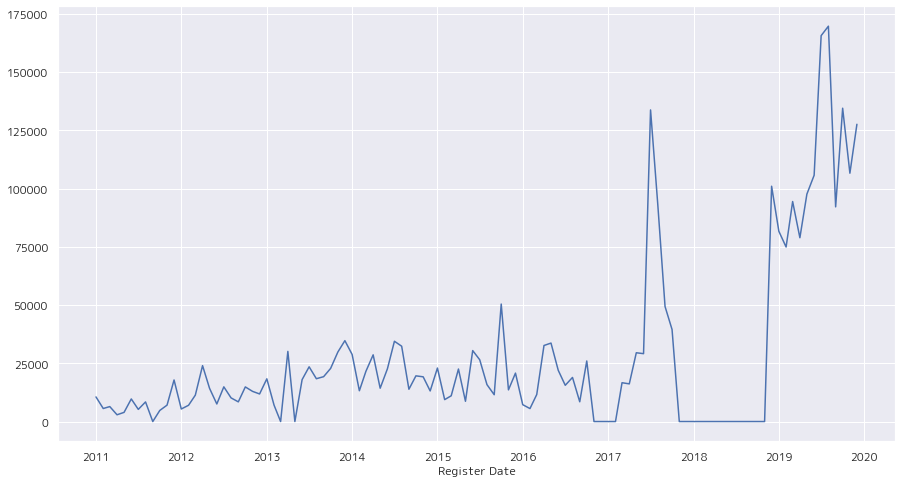

In [350]:
plt.figure(figsize=(15,8))
values = em_series.values
# plot dataset
sns.lineplot(data=em_series.resample('MS').sum())

In [115]:
em_series.describe()

count     5301.000000
mean       560.752369
std       1045.189006
min         26.060000
25%        207.080536
50%        332.200000
75%        573.790000
max      20042.000000
dtype: float64

In [117]:
names = ["Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest","LGBM","XGBoost"]
models = [
    GradientBoostingRegressor(),
    DecisionTreeRegressor(max_depth=5),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    LGBMRegressor(),
    XGBRegressor()]

In [359]:
# values = pd.DataFrame(em_series.values)
# dataframe = pd.concat([values.shift(1), values], axis=1)
# dataframe.columns = ['t-1', 't']
# dataframe.dropna(inplace= True)
# target = dataframe.iloc[:,1]
# data = dataframe.iloc[:,:-1]
dataset = series_to_supervised(np.expand_dims(em_series_sample.values,axis=1), n_in=1)
data  = dataset[:,:-1]
target = dataset[:,-1]

In [360]:
# split into train and test sets
train_X,test_X, train_y,test_y  = train_test_split(data, target, test_size = 0.5)
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# model = XGBRegressor()
# model = LGBMRegressor()
model.fit(train_X, train_y)
yhat = model.predict(test_X)
rmse = mean_squared_error(test_y, yhat,squared=False)
mape = mean_absolute_percentage_error(test_y, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 994.305
Test MAPE: 0.993


In [361]:
rmse = []
mape = []
r_squared = []
for  model in models:
    model.fit(train_X, train_y)
    y_pred  = model.predict(test_X)
#     print(y_pred)
    rmse_score = mean_squared_error(test_y, y_pred,squared=False)
    mape_score = np.mean(np.abs((test_y - y_pred)/test_y)*100)
    r_squared_score  = model.score(test_X,test_y)
    r_squared.append(r_squared_score)
    rmse.append(rmse_score)
    mape.append(mape_score)

In [362]:
df_score = pd.DataFrame()
df_score['MODELS'] = names
df_score['R_SQUARED'] = r_squared
df_score['RMSE'] = rmse
df_score['MAPE'] = mape
df_score['RMSE'] = round(df_score['RMSE'],3)
df_score['MAPE'] = round(df_score['MAPE'],3)
df_score['R_SQUARED'] = round(df_score['R_SQUARED'],3)

df_score

,MODELS,R_SQUARED,RMSE,MAPE
0,Gradient_Boosting,-0.010,975.151,96.767
1,Decision_Tree,-0.002,971.114,96.197
2,Extra_Trees,-0.042,990.236,99.416
3,Random_Forest,-0.002,971.402,97.938
4,LGBM,-0.001,970.642,100.071
5,XGBoost,-0.041,990.105,98.076


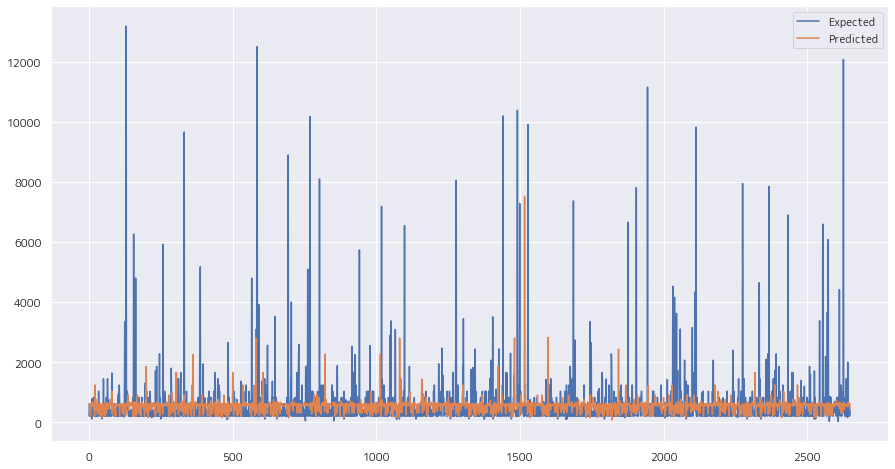

In [363]:
plt.figure(figsize=(15,8))
plt.plot(test_y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

predicted=249.110831, expected=604.000000
predicted=454.941386, expected=207.080536
predicted=393.281662, expected=347.300000
predicted=281.521146, expected=309.550000
predicted=327.259022, expected=286.510000
predicted=297.318364, expected=286.330000
predicted=286.414440, expected=286.330000
predicted=286.330000, expected=414.161071
predicted=354.193843, expected=709.700000
predicted=571.060350, expected=1425.050000
predicted=1089.494335, expected=2916.230000
predicted=2216.972143, expected=287.870000
predicted=1521.251007, expected=301.740000
predicted=295.236471, expected=301.740000
predicted=301.740000, expected=621.241607
predicted=471.429904, expected=350.310000
predicted=477.348835, expected=207.080536
predicted=274.239109, expected=694.610000
predicted=466.009922, expected=347.000000
predicted=509.994876, expected=302.000000
predicted=323.100200, expected=4348.800000
predicted=2451.199620, expected=288.910000
predicted=2196.707653, expected=271.560000
predicted=279.697535, expe

predicted=401.968941, expected=228.010000
predicted=218.161555, expected=224.990000
predicted=226.411073, expected=226.500000
predicted=225.789463, expected=229.520000
predicted=228.098926, expected=228.010000
predicted=228.720537, expected=414.161071
predicted=326.566889, expected=828.322143
predicted=633.441051, expected=1388.570000
predicted=1124.967550, expected=302.000000
predicted=813.296683, expected=302.000000
predicted=302.000000, expected=375.000000
predicted=340.653479, expected=382.500000
predicted=378.971250, expected=414.161071
predicted=399.264538, expected=207.080536
predicted=304.512067, expected=390.000000
predicted=303.935913, expected=397.500000
predicted=393.971244, expected=330.000000
predicted=361.758810, expected=207.080536
predicted=264.914117, expected=207.080536
predicted=207.080536, expected=667.500000
predicted=450.873067, expected=207.080536
predicted=423.713069, expected=1035.402679
predicted=645.642563, expected=207.080536
predicted=596.873198, expected=

predicted=207.080536, expected=414.161071
predicted=316.708170, expected=397.500000
predicted=405.340735, expected=390.000000
predicted=393.529516, expected=207.080536
predicted=293.162797, expected=207.080536
predicted=207.080536, expected=414.161071
predicted=316.708901, expected=207.080536
predicted=304.533218, expected=207.080536
predicted=207.080536, expected=594.940000
predicted=412.413067, expected=207.080536
predicted=389.610801, expected=690.000000
predicted=462.727554, expected=207.080536
predicted=434.359406, expected=272.020000
predicted=241.457752, expected=621.241607
predicted=456.889498, expected=408.020000
predicted=508.367627, expected=1242.483214
predicted=849.749089, expected=621.241607
predicted=913.637265, expected=226.500000
predicted=412.272302, expected=226.500000
predicted=226.500000, expected=228.010000
predicted=227.299379, expected=226.500000
predicted=227.210621, expected=682.500000
predicted=467.901939, expected=339.750000
predicted=501.053666, expected=20

predicted=1005.977091, expected=621.241607
predicted=1137.696675, expected=1678.110000
predicted=1180.126995, expected=207.080536
predicted=900.372040, expected=207.080536
predicted=207.080536, expected=347.300000
predicted=281.230225, expected=207.080536
predicted=273.150469, expected=1035.402679
predicted=645.096580, expected=1035.402679
predicted=1035.402679, expected=271.800000
predicted=631.583993, expected=1242.483214
predicted=785.081611, expected=1035.402679
predicted=1132.977022, expected=828.322143
predicted=925.895102, expected=1656.644286
predicted=1266.339100, expected=207.080536
predicted=890.249933, expected=543.600000
predicted=385.018676, expected=543.600000
predicted=543.600000, expected=543.600000
predicted=543.600000, expected=543.600000
predicted=543.600000, expected=543.600000
predicted=543.600000, expected=543.600000
predicted=543.600000, expected=207.080536
predicted=365.660002, expected=207.080536
predicted=207.080536, expected=207.080536
predicted=207.080536, 

predicted=726.444950, expected=288.410000
predicted=640.029247, expected=302.000000
predicted=295.603365, expected=207.080536
predicted=251.757899, expected=241.270000
predicted=225.177465, expected=414.161071
predicted=332.783608, expected=207.080536
predicted=304.550984, expected=414.161071
predicted=316.690130, expected=207.080536
predicted=304.551970, expected=414.161071
predicted=316.689144, expected=414.161071
predicted=414.161071, expected=621.241607
predicted=523.770104, expected=414.161071
predicted=511.633068, expected=207.080536
predicted=304.551180, expected=621.241607
predicted=426.297488, expected=256.670000
predicted=428.275206, expected=256.670000
predicted=256.670000, expected=256.670000
predicted=256.670000, expected=256.670000
predicted=256.670000, expected=256.670000
predicted=256.670000, expected=337.500000
predicted=299.453535, expected=828.322143
predicted=597.295644, expected=414.161071
predicted=609.107624, expected=414.161071
predicted=414.161071, expected=207

predicted=1011.429940, expected=279.350000
predicted=440.380124, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=1449.563750
predicted=898.402327, expected=385.760000
predicted=886.867465, expected=279.350000
predicted=329.467776, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=337.500000
predicted=310.112102, expected=345.000000
predicted=341.467598, expected=1995.190000
predicted=1217.974224, expected=1710.160000
predicted=1844.381726, expected=1242.483214
predicted=1462.705944, expected=1242.483214
predicted=1242.483214, expected=414.161071
predicted=804.198302, expected=1035.402679
predicted=742.862763, expected=621.241607
predicted=816.271377, expected=414.161071
predicted=511.672488, expected=1035.402679
predicted=742.861633, 

predicted=1192.723630, expected=621.241607
predicted=523.940786, expected=828.322143
predicted=731.022616, expected=414.161071
predicted=608.762835, expected=207.080536
predicted=304.377994, expected=207.080536
predicted=207.080536, expected=207.080536
predicted=207.080536, expected=414.161071
predicted=316.864016, expected=1035.402679
predicted=743.520699, expected=621.241607
predicted=815.832731, expected=279.350000
predicted=439.978194, expected=271.800000
predicted=275.347113, expected=279.350000
predicted=275.802887, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=207.080536
predicted=241.033914, expected=207.080536
predicted=207.080536, expected=337.500000
predicted=276.226826, expected=207.080536
predicted=268.353829, expected=354.000000
predicted=284.974559, expected=362.400000
predicted=358.453536, expected=362.400000
predicted=362.400000, expected=362.400000
predicted=362.400000, expected=6

predicted=382.698066, expected=414.161071
predicted=418.222473, expected=207.080536
predicted=304.434846, expected=1449.563750
predicted=865.408786, expected=347.610000
predicted=865.764889, expected=347.610000
predicted=347.610000, expected=279.350000
predicted=311.443012, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=279.350000
predicted=279.350000, expected=271.800000
predicted=275.349695, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=271.800000
predicted=271.800000, expected=207.080536
predicted=237.508940, expected=41

predicted=5290.998349, expected=2070.020000
predicted=5454.836386, expected=207.080536
predicted=1079.807074, expected=207.080536
predicted=207.080536, expected=828.322143
predicted=537.387629, expected=621.241607
predicted=718.218746, expected=241.330000
predicted=419.241437, expected=207.080536
predicted=223.119190, expected=3913.920000
predicted=2178.002562, expected=762.550000
predicted=2239.925822, expected=828.322143
predicted=797.515908, expected=294.450000
predicted=544.505751, expected=289.920000
predicted=292.041709, expected=414.161071
predicted=355.970479, expected=621.241607
predicted=524.252278, expected=1140.080000
predicted=897.080453, expected=207.080536
predicted=644.085691, expected=241.040000
predicted=225.135039, expected=241.040000
predicted=241.040000, expected=241.040000
predicted=241.040000, expected=241.040000
predicted=241.040000, expected=241.040000
predicted=241.040000, expected=241.040000
predicted=241.040000, expected=286.900000
predicted=265.421405, expe

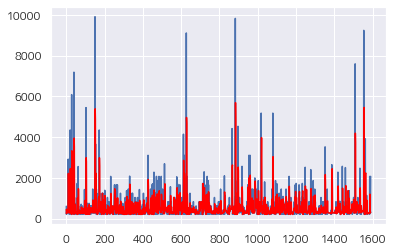

In [366]:
from statsmodels.tsa.arima.model import ARIMA

X = em_series_sample.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = mean_squared_error(test, predictions,squared=False)
mape = mean_absolute_percentage_error(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=6.506343, expected=7.412549
predicted=6.522698, expected=6.026255
predicted=6.501817, expected=7.279018
predicted=6.525054, expected=5.333108
predicted=6.491509, expected=7.279018
predicted=6.515804, expected=7.124867
predicted=6.525809, expected=7.635693
predicted=6.548457, expected=6.026255
predicted=6.529328, expected=6.026255
predicted=6.520784, expected=5.333108
predicted=6.495560, expected=5.333108
predicted=6.473502, expected=5.333108
predicted=6.451688, expected=7.124867
predicted=6.483256, expected=7.279018
predicted=6.499261, expected=7.124867
predicted=6.508596, expected=5.333108
predicted=6.468401, expected=6.026255
predicted=6.468187, expected=5.333108
predicted=6.439743, expected=6.026255
predicted=6.440893, expected=6.026255
predicted=6.433461, expected=6.431720
predicted=6.438879, expected=6.719402
predicted=6.447756, expected=5.333108
predicted=6.409873, expected=6.026255
predicted=6.411499, expected=6.719402
predicted=6.426383, expected=6.942546
predicted=6.

predicted=6.393360, expected=6.942546
predicted=6.397323, expected=8.925487
predicted=6.464568, expected=5.333108
predicted=6.402071, expected=6.026255
predicted=6.403072, expected=5.333108
predicted=6.378785, expected=6.719402
predicted=6.399198, expected=7.909690
predicted=6.436072, expected=6.668662
predicted=6.425693, expected=5.333108
predicted=6.393724, expected=7.731003
predicted=6.439053, expected=6.026255
predicted=6.416676, expected=9.100153
predicted=6.481395, expected=5.333108
predicted=6.439681, expected=6.026255
predicted=6.435699, expected=7.412549
predicted=6.456182, expected=8.418477
predicted=6.494758, expected=6.942546
predicted=6.493163, expected=8.718582
predicted=6.544119, expected=5.333108
predicted=6.500381, expected=6.719402
predicted=6.510921, expected=6.026255
predicted=6.499793, expected=7.523883
predicted=6.522776, expected=6.462501
predicted=6.517673, expected=6.036630
predicted=6.508047, expected=6.026255
predicted=6.499965, expected=6.431720
predicted=6.

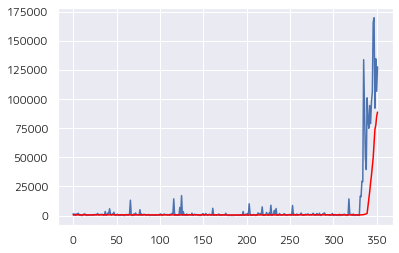

In [497]:
X = np.log(em_series).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

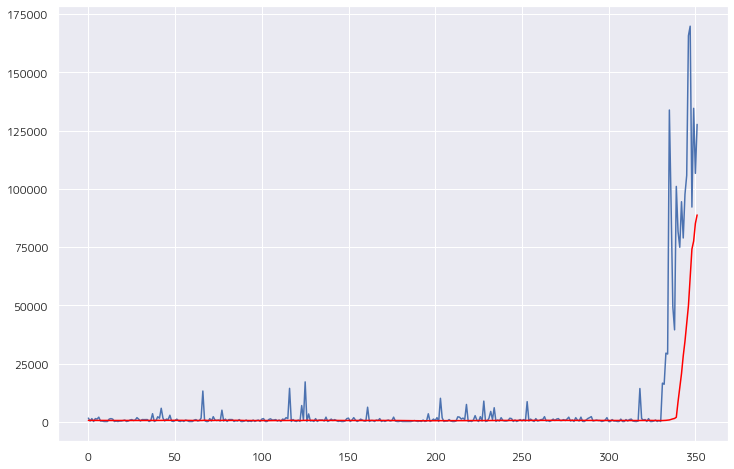

In [494]:
plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.xticks(rotation = 90)
# sns.lineplot(x=list(df_sum_month['month_year'][size:len(X)]),y=np.exp(test),data=np.exp(test))
# plt.legend(loc='upper left', labels=['forecast','test'])
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

predicted=6.041842, expected=6.403574
predicted=5.858463, expected=5.333108
predicted=5.827093, expected=5.850189
predicted=5.685599, expected=5.735120
predicted=5.724821, expected=5.657773
predicted=5.727318, expected=5.657145
predicted=5.798021, expected=5.657145
predicted=5.636690, expected=6.026255
predicted=5.779123, expected=6.564842
predicted=5.922258, expected=7.261962
predicted=6.204041, expected=7.978047
predicted=6.624057, expected=5.662509
predicted=6.482652, expected=5.709566
predicted=6.515874, expected=5.709566
predicted=6.426896, expected=6.431720
predicted=6.380921, expected=5.858818
predicted=6.237942, expected=5.333108
predicted=5.764594, expected=6.543351
predicted=5.988999, expected=5.849325
predicted=5.907849, expected=5.710427
predicted=5.946757, expected=8.377655
predicted=6.445664, expected=5.666115
predicted=6.152716, expected=5.604183
predicted=6.298308, expected=5.852202
predicted=6.215683, expected=5.422745
predicted=5.941818, expected=5.605067
predicted=6.

predicted=5.968465, expected=5.333108
predicted=5.773559, expected=6.211202
predicted=5.943137, expected=6.026255
predicted=6.088219, expected=6.026255
predicted=5.928404, expected=5.605876
predicted=6.044550, expected=6.719402
predicted=6.014136, expected=5.487283
predicted=5.971973, expected=5.487283
predicted=5.881249, expected=5.805737
predicted=5.871363, expected=5.805737
predicted=5.765560, expected=5.805737
predicted=5.872116, expected=5.333108
predicted=5.612876, expected=5.518055
predicted=5.618102, expected=5.799093
predicted=5.676917, expected=6.719402
predicted=5.869647, expected=5.605876
predicted=5.795707, expected=7.635693
predicted=6.215481, expected=6.180431
predicted=6.232528, expected=6.186661
predicted=6.339175, expected=6.011316
predicted=6.419291, expected=6.339036
predicted=6.258072, expected=5.852202
predicted=6.355317, expected=5.487283
predicted=5.981948, expected=5.605876
predicted=5.902349, expected=5.605876
predicted=5.780055, expected=6.431720
predicted=5.

predicted=5.945682, expected=5.333108
predicted=5.929568, expected=6.115892
predicted=5.579977, expected=5.333108
predicted=5.572993, expected=5.333108
predicted=5.472712, expected=6.026255
predicted=5.612980, expected=6.026255
predicted=5.673860, expected=6.026255
predicted=5.848501, expected=5.664383
predicted=5.746999, expected=7.279018
predicted=6.119440, expected=6.431720
predicted=6.235810, expected=6.857409
predicted=6.429255, expected=6.431720
predicted=6.478706, expected=6.719402
predicted=6.528958, expected=6.942546
predicted=6.805932, expected=5.333108
predicted=6.370489, expected=5.333108
predicted=6.244748, expected=7.412549
predicted=6.401192, expected=6.538719
predicted=6.328656, expected=5.849325
predicted=6.280463, expected=7.446200
predicted=6.429268, expected=5.710427
predicted=6.255534, expected=6.719402
predicted=6.657303, expected=5.333108
predicted=6.232342, expected=5.333108
predicted=5.974099, expected=5.333108
predicted=5.980143, expected=6.026255
predicted=5.

predicted=5.789643, expected=6.026255
predicted=5.873409, expected=6.431720
predicted=6.019346, expected=5.333108
predicted=5.856333, expected=6.026255
predicted=6.105021, expected=5.333108
predicted=5.702043, expected=6.431720
predicted=5.941776, expected=5.805737
predicted=5.903282, expected=5.805737
predicted=5.782444, expected=5.850189
predicted=5.903135, expected=5.850189
predicted=5.814192, expected=6.431720
predicted=6.062448, expected=5.709334
predicted=5.893072, expected=5.709334
predicted=5.895389, expected=5.709334
predicted=5.871985, expected=5.709334
predicted=5.818825, expected=5.709334
predicted=5.833617, expected=6.719402
predicted=5.926252, expected=5.805737
predicted=5.879398, expected=5.709334
predicted=5.904041, expected=5.804683
predicted=5.917278, expected=5.709334
predicted=5.858845, expected=5.709334
predicted=5.911822, expected=6.026255
predicted=5.810074, expected=6.026255
predicted=5.835488, expected=6.026255
predicted=5.897300, expected=5.333108
predicted=5.

predicted=6.165384, expected=6.148682
predicted=6.164261, expected=6.148682
predicted=6.169661, expected=8.393304
predicted=6.642164, expected=6.942546
predicted=6.676904, expected=5.333108
predicted=6.497986, expected=5.605067
predicted=6.424963, expected=5.605067
predicted=6.215638, expected=5.850189
predicted=6.251776, expected=5.605067
predicted=5.835754, expected=5.892335
predicted=5.663540, expected=5.892335
predicted=5.750513, expected=5.333108
predicted=5.671198, expected=6.339036
predicted=5.860844, expected=6.440372
predicted=5.929061, expected=5.333108
predicted=5.841630, expected=5.333108
predicted=5.791307, expected=6.719402
predicted=5.936721, expected=6.942546
predicted=6.191812, expected=6.942546
predicted=6.352110, expected=9.192991
predicted=6.919629, expected=5.333108
predicted=6.636831, expected=5.333108
predicted=6.717400, expected=6.942546
predicted=6.788871, expected=6.719402
predicted=6.619821, expected=5.333108
predicted=6.488902, expected=5.333108
predicted=5.

predicted=6.735198, expected=5.602820
predicted=6.272446, expected=5.602820
predicted=6.295549, expected=5.602820
predicted=6.248476, expected=6.719402
predicted=6.358517, expected=5.484631
predicted=6.235622, expected=5.484631
predicted=5.754256, expected=5.484631
predicted=5.728000, expected=5.484631
predicted=5.660082, expected=5.484631
predicted=5.691285, expected=5.484631
predicted=5.484631, expected=5.484631
predicted=5.484631, expected=5.484631
predicted=5.484631, expected=5.333108
predicted=5.451619, expected=7.530332
predicted=5.907993, expected=5.333108
predicted=5.723990, expected=5.850189
predicted=5.872504, expected=6.026255
predicted=5.955946, expected=5.659134
predicted=5.872544, expected=6.431720
predicted=6.194775, expected=6.431720
predicted=5.971317, expected=7.444319
predicted=6.373341, expected=6.431720
predicted=6.414539, expected=6.942546
predicted=6.590213, expected=5.659134
predicted=6.509508, expected=5.659134
predicted=6.367030, expected=5.659134
predicted=6.

predicted=6.210605, expected=6.719402
predicted=6.053246, expected=6.719402
predicted=6.212639, expected=7.279018
predicted=6.389615, expected=6.026255
predicted=6.383754, expected=5.333108
predicted=6.360275, expected=6.719402
predicted=6.490473, expected=5.652559
predicted=6.200765, expected=5.865051
predicted=6.145942, expected=5.333108
predicted=5.815149, expected=5.659134
predicted=5.725068, expected=5.659134
predicted=5.812581, expected=5.659134
predicted=5.629085, expected=5.843544
predicted=5.692628, expected=5.834811
predicted=5.671101, expected=5.632465
predicted=5.710916, expected=5.632465
predicted=5.710572, expected=5.632465
predicted=5.697632, expected=5.632465
predicted=5.692952, expected=5.632465
predicted=5.665960, expected=5.632465
predicted=5.632465, expected=5.333108
predicted=5.566587, expected=6.026255
predicted=5.674831, expected=6.026255
predicted=5.725940, expected=6.026255
predicted=5.794541, expected=6.431720
predicted=5.962877, expected=5.333108
predicted=5.

predicted=6.301731, expected=5.632465
predicted=6.250821, expected=6.547503
predicted=6.286706, expected=5.852202
predicted=6.362744, expected=6.431720
predicted=5.998460, expected=6.719402
predicted=6.182695, expected=6.719402
predicted=6.322740, expected=5.333108
predicted=6.227776, expected=6.431720
predicted=6.270960, expected=5.333108
predicted=6.085376, expected=6.431720
predicted=6.167021, expected=5.616626
predicted=5.973994, expected=6.942546
predicted=6.054949, expected=5.632465
predicted=6.055466, expected=5.632465
predicted=5.904080, expected=5.632465
predicted=5.984669, expected=5.632465
predicted=5.793446, expected=6.440388
predicted=6.027687, expected=6.298214
predicted=5.899357, expected=6.298214
predicted=6.016383, expected=5.871695
predicted=6.034468, expected=5.632465
predicted=5.995298, expected=6.026255
predicted=6.089915, expected=7.812868
predicted=6.405808, expected=6.026255
predicted=6.251077, expected=5.333108
predicted=6.103897, expected=5.850189
predicted=6.

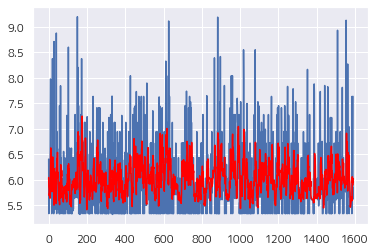

In [447]:
X = np.log(em_series_sample).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA')
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

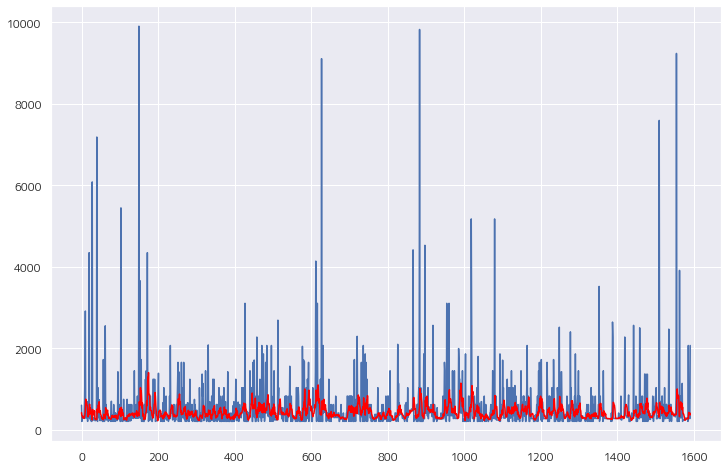

In [488]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

ValueError: arrays must all be same length

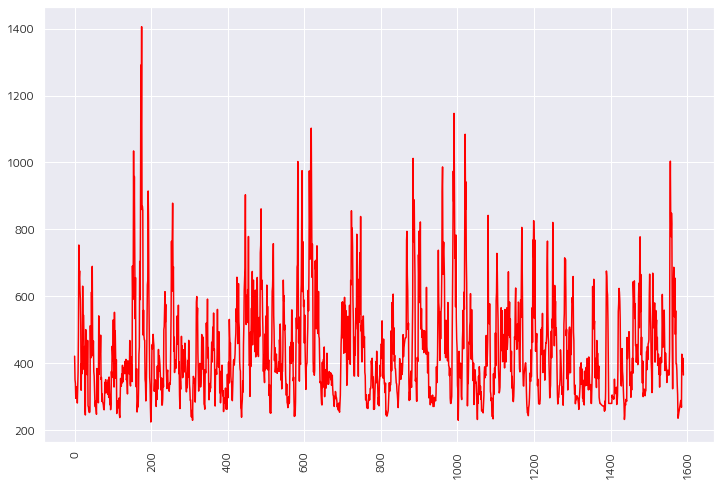

In [462]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
sns.lineplot(x=list(df_sum_day['Register Date'][size:len(X)]),y=np.exp(test),data=np.exp(test))
plt.legend(loc='upper left', labels=['forecast','test'])

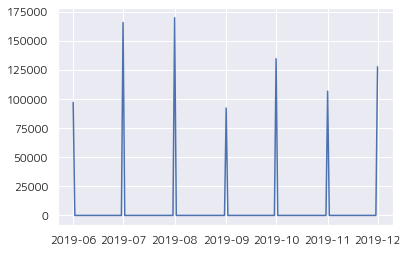

In [327]:
size = int(len(X) * 0.7)

plt.plot(em_series[size:len(X)].resample('D').sum())

In [444]:
X = np.log(em_series_month).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=9.582837, expected=10.424835
predicted=9.829943, expected=9.998527
predicted=9.854886, expected=9.652597
predicted=9.795264, expected=9.848727
predicted=9.815001, expected=9.045256
predicted=9.616080, expected=10.165825
predicted=9.766593, expected=9.721253
predicted=9.750388, expected=9.690925
predicted=9.737168, expected=10.293276
predicted=9.863727, expected=10.279925
predicted=9.958963, expected=11.804116
predicted=10.492014, expected=11.441675
predicted=10.825767, expected=10.807477
predicted=10.753820, expected=10.584488
predicted=10.669296, expected=11.523194
predicted=11.020173, expected=11.310821
predicted=11.102752, expected=11.224400
predicted=11.137711, expected=11.455962
predicted=11.256312, expected=11.276195
predicted=11.253246, expected=11.489231
predicted=11.341676, expected=11.568823
predicted=11.420657, expected=12.017912
predicted=11.643412, expected=12.042098
predicted=11.785994, expected=11.431496
predicted=11.632585, expected=11.809558
predicted=11.7108

In [484]:
# plt.xticks(rotation = 90)
# plt.plot_date(df_sum_month['month_year'][size:len(X)], np.exp(predictions))
list_time_test = list(df_sum_month['month_year'][size:len(X)])
list_time_test

[]

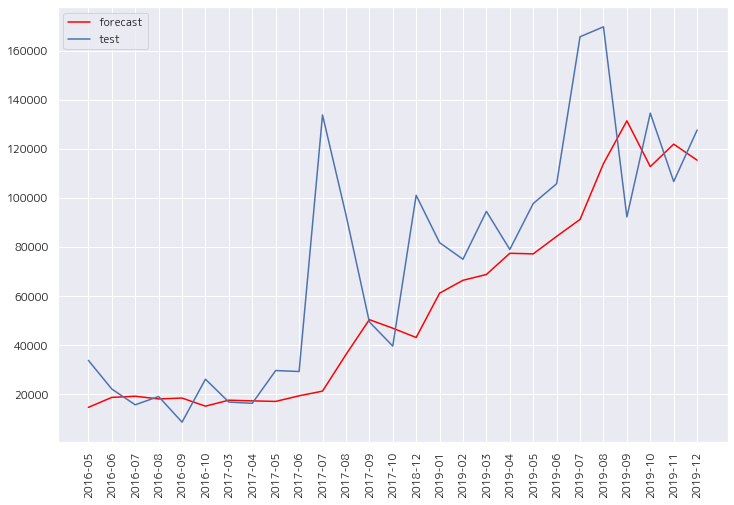

In [446]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
sns.lineplot(x=list_time_test,y=np.exp(test),data=np.exp(test))
plt.legend(loc='upper left', labels=['forecast','test'])

D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum

predicted=12.298228, expected=12.404300
predicted=12.078985, expected=12.110167
predicted=11.646545, expected=12.917413


D:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=11.705074, expected=11.523194
predicted=12.273738, expected=14.100581
RMSE: 516148.677
MAPE: 0.378


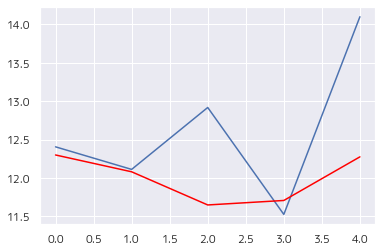

In [261]:
X = np.log(em_series_year).values
size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

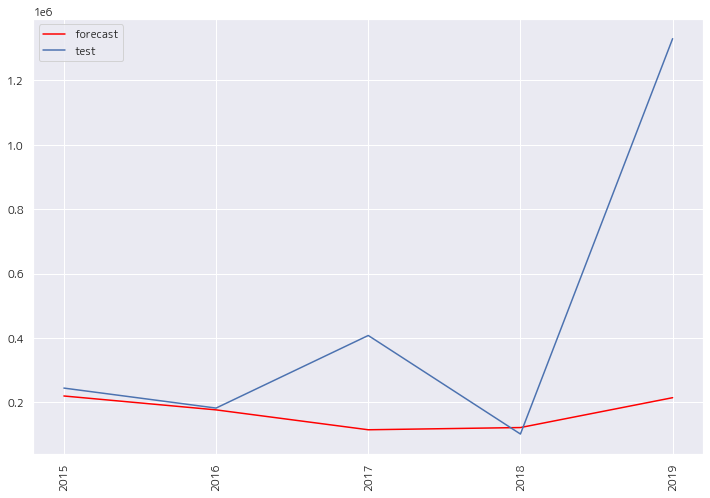

In [262]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
sns.lineplot(x=list(df_sum_year['year'][size:len(X)]),y=np.exp(test),data=np.exp(test))
plt.legend(loc='upper left', labels=['forecast','test'])

In [663]:
mod =SARIMAX(em_series_month,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4112      0.263      1.561      0.118      -0.105       0.927
ma.L1         -1.1563      0.058    -19.823      0.000      -1.271      -1.042
ar.S.L12      -0.5223      0.439     -1.191      0.234      -1.382       0.337
sigma2      5.753e+08   6.83e-10   8.43e+17      0.000    5.75e+08    5.75e+08


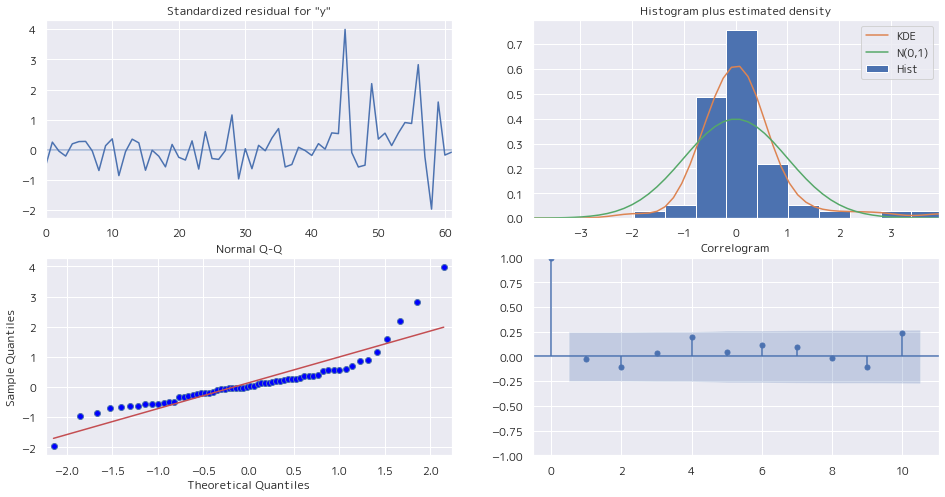

In [664]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

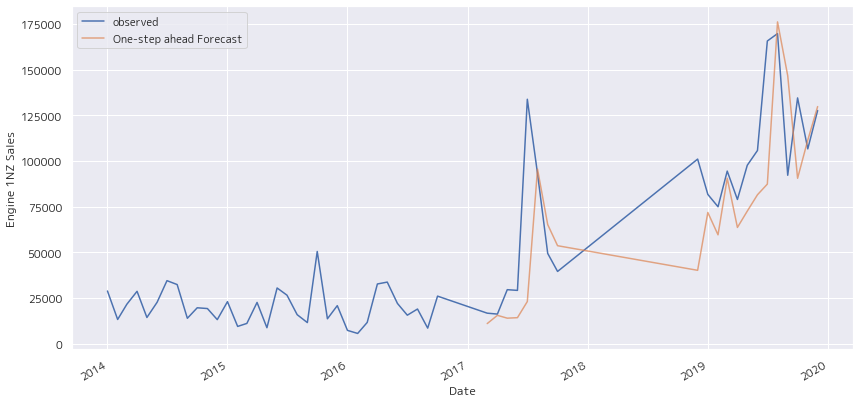

In [690]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2014-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Engine 1NZ Sales')
plt.legend()

plt.show()

In [668]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 37700.070
MAPE: 0.290


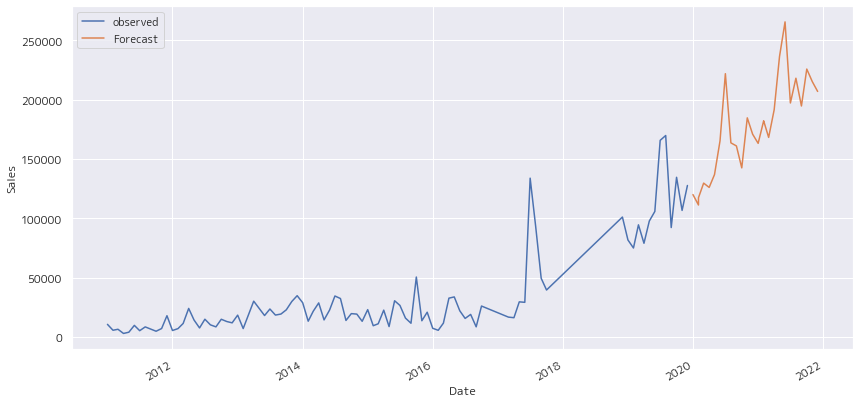

In [689]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [687]:
pred_uc.predicted_mean

2020-01-01    119961.583538
2020-02-01    111186.505977
2020-03-01    129631.403954
2020-02-01    117319.070937
2020-04-01    126004.535457
2020-05-01    136846.595375
2020-06-01    165278.431357
2020-07-01    221878.931149
2020-08-01    163575.202084
2020-09-01    160965.206951
2020-10-01    142480.338649
2020-11-01    184643.801146
2020-12-01    170881.138201
2021-01-01    163156.316074
2021-02-01    182165.901985
2021-03-01    168166.516353
2021-02-01    182102.298344
2021-04-01    191507.295440
2021-05-01    236399.443105
2021-06-01    265556.577688
2021-07-01    197188.711660
2021-08-01    218062.138458
2021-09-01    194658.849453
2021-10-01    225771.875435
2021-11-01    215189.021033
2021-12-01    206915.659512
Name: predicted_mean, dtype: float64